# COMP30027 Project 2 Code
### Student Name: Ider Byambadorj
### Student ID: 1198613
Acknowledgement: Some functions from sklearn have been implemented in this code. Doc2Vec vector matrices provided with the assignment has been used in this code.

# Training Phase
## Read the training data

In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv(r"book_rating_train.csv", index_col = False, delimiter = ',', header=0)
print(train_data.shape)

(23063, 10)


### Doc2vec matrices

In [2]:

train_name = pd.read_csv(r"train_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
train_author = pd.read_csv(r"train_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
train_desc = pd.read_csv(r"train_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)

name_dict = {}
author_dict = {}
desc_dict = {}

# all column names in the doc2vec matrices are 0-100 or 0-20. We need to change
# the column names.
for i in range(100):
    name_dict[i] = "name_" + str(i)
    desc_dict[i] = "desc_" + str(i)
    if i < 20:
        author_dict[i] = "author_" + str(i)

train_name.rename(columns=name_dict, inplace=True)
train_author.rename(columns=author_dict, inplace=True)
train_desc.rename(columns=desc_dict, inplace=True)

## Preprocessing

### Feature Selection
1. Drop Language
2. Drop Name, Authors, Desc
3. Encode Publisher
4. Concat everything

In [3]:
print(train_data.isna().sum())
print(train_data['Language'].value_counts().head())

Name                0
Authors             0
PublishYear         0
PublishMonth        0
PublishDay          0
Publisher         148
Language        17202
pagesNumber         0
Description         0
rating_label        0
dtype: int64
eng    5450
fre     154
spa     149
ger      59
jpn       8
Name: Language, dtype: int64


From the output above, the feature **Language** has too many missing values. Intuitively, the language of the book doesn't provide any reasonable explanation for the rating. Since it is not a numerical variable, but categorical variable, we don't have any reasonable ways to impute the missing values. In addition, most of the books in the dataset is written in english, so the distribution of the dataset is too biased towards one language. Therefore, it doesn't provide any useful information to the classifier. Considering all these factors, we remove the feature 'Language' during the preprocessing phase.

In [4]:
from sklearn.preprocessing import OneHotEncoder

# Feature selection
train_data.drop(['Language', 'Name', 'Authors', 'Description'], axis=1, inplace=True)

# Encode the Publisher feature
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=2)
publisher_encoded = encoder.fit_transform(train_data[['Publisher']])
publisher_encoded_df = pd.DataFrame(publisher_encoded, columns=encoder.get_feature_names_out(['Publisher']))

data_encoded = pd.concat([train_data, train_name, train_author, train_desc, publisher_encoded_df], axis=1)

# Remove any more missing values before separating X and y to keep order of indexes.
data_encoded.dropna(inplace=True)

# Remove publisher because we have already encoded this feature
data_encoded.drop(['Publisher'], axis=1, inplace=True)

y_train = data_encoded['rating_label']
X_train = data_encoded.drop(['rating_label'], axis=1)
X_train.columns = X_train.columns.astype(str)
print(X_train.shape)

(22915, 2259)


In [5]:
print(y_train.value_counts())

4.0    16108
3.0     5827
5.0      980
Name: rating_label, dtype: int64


The target variable is imbalanced.

## Training the model

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Optimizing Hyperparameters
### kNN
Note: This part is optional to run. It takes long time to run each step. Since the parameters have already been tuned, it is unnecessary to run. If you want to run this part of the code, uncomment all the codes below.

In [7]:
# from sklearn.model_selection import GridSearchCV

# scaler = StandardScaler()

# knn = KNeighborsClassifier()
# knn_pipeline = Pipeline([('scaler', scaler), ('knn', knn)])

# kValues = [2, 3, 5, 7, 10, 20, 25, 30, 40, 50]
# knn_param_grid = {'knn__n_neighbors': kValues}

# gs = GridSearchCV(knn_pipeline,
#                   param_grid=knn_param_grid,
#                   scoring='accuracy',
#                   cv=2,
#                   n_jobs=-1,
#                   verbose=1)
# gs.fit(X_train, y_train)
# best_params = gs.best_params_
# print('Best Parameter for kNN:', best_params)

In [8]:
# from sklearn.model_selection import cross_val_score
# import matplotlib.pyplot as plt
# k_values = [2, 3, 5, 7, 10, 20, 25, 30, 40, 50]
# acc_values = []
# for k in k_values:
#     knn_clf = KNeighborsClassifier(n_neighbors=k)
#     pipeline2 = Pipeline([('scaler', scaler), ('estimator', knn_clf)])
#     result = cross_val_score(pipeline2, X_train, y_train, cv=3)
#     acc_values.append(np.mean(result))

# plt.plot(k_values, acc_values)
# plt.xlabel("Different k-values for k-NN classifier")
# plt.ylabel("Accuracy score")
# plt.title("Accuracy vs. k-values in k-NN classifier")
# plt.show()


From the plot and GridSearch, we can see that **k=30** is the appropriate value for our k-NN classifier. Next we try to optimise the hyperparameters for our MLPClassifier.

### Neural Network - MLP
Optimize the activation function and solver.

In [9]:
# mlp = MLPClassifier()
# pipeline = Pipeline([('scaler', scaler), ('mlp', mlp)])

# mlp_param_grid = {'mlp__activation': ['relu', 'logistic', 'tanh'], 
#                   'mlp__solver': ['adam', 'sgd'],
#                   'mlp__learning_rate': ['constant','adaptive']}

# gs = GridSearchCV(pipeline,
#                   param_grid=mlp_param_grid,
#                   scoring='accuracy',
#                   cv=2,
#                   n_jobs=-1,
#                   verbose=1)

# gs.fit(X_train, y_train)

# best_params = gs.best_params_
# print('Best parameters for MLP: ', best_params)

From the GridSearchCV over the activation function and solver, we found that the optimal parameters are **activation=logistic** **solver=sgd** and **learning_rate=adaptive** . Next, we optimize the alpha and hidden_layer_sizes values.

In [10]:
# mlp = MLPClassifier(activation='logistic', solver='sgd', learning_rate='adaptive')
# pipeline = Pipeline([('scaler', scaler), ('mlp', mlp)])

# mlp_param_grid = {'mlp__hidden_layer_sizes': [(100,), (50,50,50), (10,10)], 
#                   'mlp__alpha': [0.0001, 0.001, 0.1, 1, 10]}

# gs = GridSearchCV(pipeline,
#                   param_grid=mlp_param_grid,
#                   scoring='accuracy',
#                   cv=2,
#                   n_jobs=-1,
#                   verbose=1)

# gs.fit(X_train, y_train)

# best_params = gs.best_params_
# print('Best Parameters for MLP: ', best_params)

From this search, the best parameters for MLP are: **alpha=10** and **hidden_layer_sizes=[100]**

### Logistic Regression

No parameter was exclusively set for Logistic Regression. We only set max_iter = 1000

## Evaluation
Using the parameters obtained from GridSearch above, we now compare and evaluate the models on the training data. The metrics will be accuracy, precision, and recall scores.

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import time
import warnings
warnings.filterwarnings(action='ignore')

scaler = StandardScaler()

knn_clf = KNeighborsClassifier(n_neighbors=30)
mlp_clf = MLPClassifier(activation='logistic', solver='sgd', learning_rate='adaptive', alpha=10, hidden_layer_sizes=(100,))
lgc_clf = LogisticRegression(max_iter = 1000)
dummy = DummyClassifier(strategy="most_frequent")

knn_pipeline = Pipeline([('scaler', scaler), ('estimator', knn_clf)])
mlp_pipeline = Pipeline([('scaler', scaler), ('estimator', mlp_clf)])
lgc_pipeline = Pipeline([('scaler', scaler), ('estimator', lgc_clf)])


classifiers = [knn_pipeline, mlp_pipeline, lgc_pipeline, dummy]
titles = ["kNN", "MLP-NN", "LR", "Zero-R"]
for title, model in zip(titles, classifiers):
    start = time.time()
    result = cross_validate(model, X_train, y_train, cv=5, scoring=('accuracy', 'precision_weighted'))
    end = time.time()

    acc = round(np.mean(result['test_accuracy']), 7)
    precision = round(np.mean(result['test_precision_weighted']), 7)

    print(title, "- acc:", acc, "pre:", precision, "time:", round(end-start, 5))

kNN - acc: 0.7048658 pre: 0.6548536 time: 13.68782
MLP-NN - acc: 0.7042112 pre: 0.6403735 time: 916.37323
LR - acc: 0.6953087 pre: 0.6579908 time: 132.89717
Zero-R - acc: 0.7029457 pre: 0.4941326 time: 0.51078


It should be noted that since the cross validation is random, we can get different results everytime, however the difference or the relationship between these metrics were seen in all runs. Thus, it is generalisable.

### Confusion Matrix for kNN

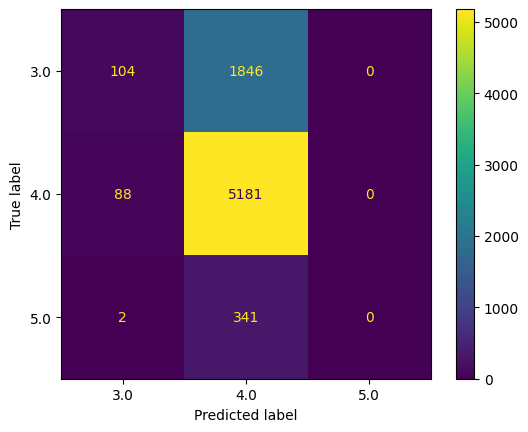

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, test_size=0.33, shuffle=True, random_state=2)

knn_pipeline.fit(train_x, train_y)
pred_y = knn_pipeline.predict(test_x)
cm = confusion_matrix(test_y, pred_y, labels=knn_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_pipeline.classes_)
disp.plot()

### Confusion Matrix for MLP - NN

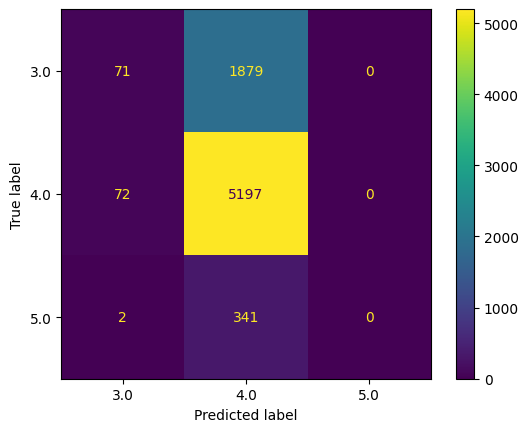

In [13]:
mlp_pipeline.fit(train_x, train_y)
pred_y = mlp_pipeline.predict(test_x)
cm = confusion_matrix(test_y, pred_y, labels=mlp_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_pipeline.classes_)
disp.plot()

### Confusion Matrix for Logistic Regression

4.0    6255
3.0    1103
5.0     204
dtype: int64


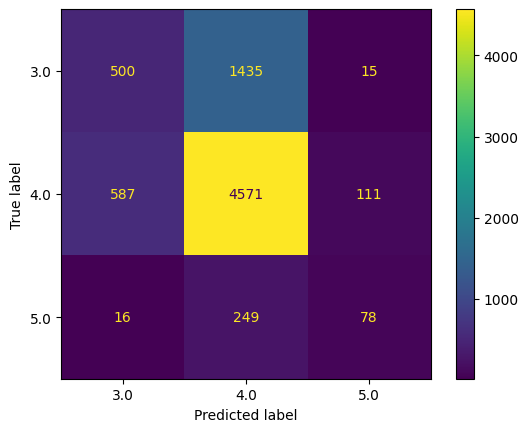

In [14]:
lgc_pipeline.fit(train_x, train_y)
pred_y = lgc_pipeline.predict(test_x)
cm = confusion_matrix(test_y, pred_y, labels=lgc_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgc_pipeline.classes_)
disp.plot()
print(pd.Series(pred_y).value_counts())


# Test phase
### Read the test data

In [15]:
test_orig = pd.read_csv(r"book_rating_test.csv", index_col = False, delimiter = ',', header=0)
test_name = pd.read_csv(r"test_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
test_author = pd.read_csv(r"test_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
test_desc = pd.read_csv(r"test_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)

test_name.rename(columns=name_dict, inplace=True)
test_author.rename(columns=author_dict, inplace=True)
test_desc.rename(columns=desc_dict, inplace=True)

### Preprocess the test data
1. Drop Language
2. Drop Name, Authors, Desc
3. Encode Publisher
4. Concat everything

In [16]:
test_data = test_orig.drop(['Language', 'Name', 'Authors', 'Description'], axis=1)

transformed_test = encoder.transform(test_data[['Publisher']])
transformed_df_test = pd.DataFrame(transformed_test, columns=encoder.get_feature_names_out(['Publisher']))

df_encoded_test = pd.concat([test_data, test_name, test_author, test_desc, transformed_df_test], axis=1)
X_test = df_encoded_test.drop(['Publisher'], axis=1)
X_test.columns = X_test.columns.astype(str)

### Testing on the test data

See report for more details on the final model selection.

In [18]:
scaler = StandardScaler()

knn_clf = KNeighborsClassifier(n_neighbors=30)
mlp_clf = MLPClassifier(activation='logistic', solver='sgd', learning_rate='adaptive', alpha=10, hidden_layer_sizes=(100,))
lgc_clf = LogisticRegression(max_iter = 1000)

classifiers = [knn_clf, mlp_clf, lgc_clf]
titles = ['knn', 'nn', 'lgc']

for title, clf in zip(titles, classifiers):
    pipeline = Pipeline([('scaler', scaler), ('estimator', clf)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    filename = title + "_predictions.csv"

    y_pred_df = pd.DataFrame(y_pred)
    y_pred_df.index += 1
    y_pred_df.columns=["rating_label"]
    y_pred_df.to_csv(filename, index_label="id")